# Machine Learning Pipeline - Feature Engineering

In the following notebooks, we will go through the implementation of each one of the steps in the Machine Learning Pipeline. 

We will discuss:

1. Data Analysis
2. **Feature Engineering**
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [2]:
#Snowflake connection info
from config import snowfalke_conn_prop
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowfalke_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 2, 0, None)
[Row(CURRENT_WAREHOUSE()='LAB_L_WH', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='TELCO')]


In [3]:
%%time
raw = session.table('TELCO_TRAIN')
data = raw.toPandas()

CPU times: user 873 ms, sys: 221 ms, total: 1.09 s
Wall time: 4.12 s


In [4]:
data.shape

(40000, 20)

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

In [5]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

# to divide train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['CHURNVALUE'], axis=1), # predictive variables
    data['CHURNVALUE'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape


((32000, 19), (8000, 19))

In [6]:
# let's identify the categorical variables
# we will capture those of type *object*

cat_vars = ['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
            'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES',
            'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']
num_vars = [ 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']

features = cat_vars + num_vars
print(cat_vars)
# number of categorical variables
len(cat_vars)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']


16

In [7]:
X_train[features].columns

Index(['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE',
       'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP',
       'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES',
       'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'TENUREMONTHS',
       'MONTHLYCHARGES', 'TOTALCHARGES'],
      dtype='object')

## Numerical variable transformation

### Logarithmic transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the logarightm the positive numerical variables in order to get a more Gaussian-like distribution.

In [8]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

In [9]:
# setup pipeline

#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

# Model Pipeline
ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)) ,
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    )

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
    )

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

# fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x7f2088bd7af0>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

In [10]:
#Check Accuracy of our model on test dataset
y_pred = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed.
   - Model Balanced Accuracy: 99.64%


In [11]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  2565
False Positive(FP) =  22
True Negative(TN)  =  5405
False Negative(FN) =  8
Accuracy of the classification = 0.996


Text(0.5, 0, 'Feature Importance')

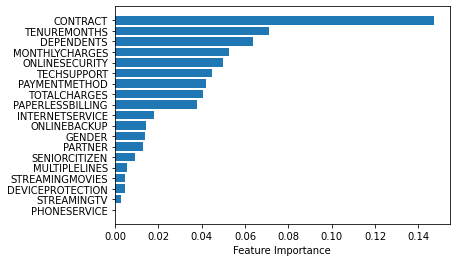

In [12]:
# Feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

In [14]:
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


In [15]:
%%time
@udf(name='predict_churn_new',is_permanent = True, stage_location = '@MODELSTAGE', replace=True)
def predict_churn_new(GENDER: str, SENIORCITIZEN: bool, PARTNER: bool, DEPENDENTS: bool,PHONESERVICE: bool,
                  MULTIPLELINES: str, INTERNETSERVICE: str, ONLINESECURITY: str, ONLINEBACKUP: str,
                  DEVICEPROTECTION: str, TECHSUPPORT: str, STREAMINGTV: str, STREAMINGMOVIES: str,
                  CONTRACT: str, PAPERLESSBILLING: str, PAYMENTMETHOD: str, TENUREMONTHS: int,
                  MONTHLYCHARGES: float, TOTALCHARGES: float) -> int:
    rw = np.asarray([GENDER, SENIORCITIZEN, PARTNER, DEPENDENTS, PHONESERVICE,
                     MULTIPLELINES, INTERNETSERVICE, ONLINESECURITY, ONLINEBACKUP,
                     DEVICEPROTECTION, TECHSUPPORT, STREAMINGTV, STREAMINGMOVIES,
                     CONTRACT, PAPERLESSBILLING, PAYMENTMETHOD, TENUREMONTHS,
                     MONTHLYCHARGES, TOTALCHARGES])
    row_dict= dict(zip(features,rw)) 
    row = pd.DataFrame(row_dict, index=[0])
    return model.predict(row)[0]

In [19]:
new_df = session.table('TRAIN_DATASET').sample(n = 500)

In [20]:
%%time
new_df.select(new_df.CUSTOMERID,new_df.CHURNVALUE,
              predict_churn_new(new_df.GENDER, new_df.SENIORCITIZEN, new_df.PARTNER, new_df.DEPENDENTS, new_df.PHONESERVICE,
                            new_df.MULTIPLELINES, new_df.INTERNETSERVICE, new_df.ONLINESECURITY, new_df.ONLINEBACKUP,
                            new_df.DEVICEPROTECTION, new_df.TECHSUPPORT, new_df.STREAMINGTV, new_df.STREAMINGMOVIES,
                            new_df.CONTRACT, new_df.PAPERLESSBILLING, new_df.PAYMENTMETHOD, new_df.TENUREMONTHS,
                            new_df.MONTHLYCHARGES, new_df.TOTALCHARGES).alias('PREDICTED_CHURN')) \
        .write.mode('overwrite').saveAsTable('churn_detection')


CPU times: user 191 ms, sys: 6.22 ms, total: 198 ms
Wall time: 56.4 s


In [18]:
session.table('churn_detection').sample(n=10).toPandas()

,CUSTOMERID,CHURNVALUE,PREDICTED_CHURN
0,4171-Dbc05,0,0
1,6075-gfb7d,0,0
2,4517-yrr3j,0,0
3,8350-NFBk6,1,1
4,5394-uc5Cj,0,0
5,2184-H4kCi,0,0
6,2050-ct8kp,0,0
7,9636-IHtfO,0,0
8,9072-VYnhi,0,0
9,4271-zS8Rx,1,1
